In [1]:
%load_ext autoreload
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from os.path import expanduser
#from lib.definitions.classdefinitions import *
import lib.definitions.classdefinitions as classdef
import lib.filter as filter
import lib.sqlite_load as sq
import lib.util as util
import lib.plot as plot
import pandas as pd
import logging
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import prettyprinter as pp
import importlib

FLOW_LABELS = [0, 255, 65280, 983040, 1048575]

vantage_point: str = classdef.VantagePoint.lon
db_path = "/home/erlend/db-storage/large-data/" + classdef.Databases.lon

logging.basicConfig(level=logging.CRITICAL)
vp = classdef.VantagePoint()
home = expanduser("~")
# Test/small data:
db_dir = home + "/git/scripts/stats/sample-data/db/*.db"

# Evaluation

# Vantage Point: lon (London, United Kingdom)

## Stats

In [3]:
test: bool = False
if test:
    db_path = home + "/git/scripts/stats/sample-data/db/db-ubuntu-fra1-0-2023-01-22T17_04_15Z.db"
    df: pd.DataFrame = sq.load_single(db_path)
else:
    df: pd.DataFrame = sq.load_single(db_path)
stats = util.create_stats(df)
pp.pprint(stats)

TracerouteStatistics(num_rows_total=155268, num_cycles=42389, num_cycle_rows=21315, num_loops=80278, num_loop_rows=40022, num_fl_changes=127, num_fl_change_rows=127, num_unique_asns_in_dataset=15612, num_invalid_rows=51942, n_traceroutes_to_the_same_destination_with_the_same_flow_label=2, num_vantage_points=8)


# Flow label persistence
### Does the flow label change in-transit?

In [4]:
def count_rows_with_path_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return len(indices)

def get_num_rows(df: pd.DataFrame) -> int:
    """
    Get total number of rows in the dataframe.
    """
    return len(df)

def count_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    num_flow_label_changes: int = 0
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = returned_flow_labels.split(" ")
        for val in flow_labels:
            if src_fl != val:
                num_flow_label_changes += 1
    return num_flow_label_changes

print(f"Total number of rows: {get_num_rows(df)}")
print(f"Total number of flow label changes: {count_flow_label_changes(df)}")
print(f"Total number of rows with flow label changes: {count_rows_with_path_flow_label_changes(df)}")

Total number of rows: 155268
Total number of flow label changes: 141
Total number of rows with flow label changes: 127


# Counting loops
## How many loops were detected in the dataset?

In [5]:
def get_hop_ip_list(df: pd.DataFrame, row_idx: int) -> list:
    hop_ip_str: str = df['HOP_IP_ADDRESSES'][row_idx]
    hop_ip_list: list = hop_ip_str.split(" ")
    return hop_ip_list

def count_loops(df: pd.DataFrame) -> int:
    nloops = 0
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip: str = hop_ip_list[0]
        for ip in hop_ip_list[1:]:
            if ip == prev_ip:
                nloops += 1
            prev_ip = ip
    return nloops
result = count_loops(df)
pp.pprint(result)

80278


## How many rows (traces) contain a loop?

In [6]:
def count_loop_rows(df: pd.DataFrame) -> int:
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    indices.append(row_idx)
                    break
            prev_ip = ip
    return len(indices)

result = count_loop_rows(df)
pp.pprint(result)

40022


# Counting cycles
## How many cycles exist in the dataset?

In [7]:
def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def count_cycles(df: pd.DataFrame) -> int:
    """
    Count the number of cycles in the dataset. If there are multiple 
    cycles in each row, each will be counted as a separate cycle.
    A cycle is where the same IP address appears twice, separated by 
    at least one other IP address.
    """
    cycle_count = 0
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    cycle_count += 1
    return cycle_count

num_cycles = count_cycles(df)
pp.pprint(num_cycles)

42389


## How many rows (traces) contain a cycle?

In [8]:
def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def count_cycle_rows(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows that contain one or more cycles in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    indices.append(row_idx)
                    break # Uncomment this if we only want to count 1 cycle per row.
    return len(indices)

result = count_cycle_rows(df)
pp.pprint(result)

21315


# Filtering
## How many invalid traces do we have?
### Causes of invalid traces:
1. Loops
2. Cycles
3. Loop-siblings and cycle-sibings
4. Flow label changes in-transit

In [9]:
def get_rows_with_path_flow_label_changes(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return indices

def get_cycle_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain one or more cycles in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    indices.append(row_idx)
                    # Uncomment this if we only want to count 1 cycle per row.
                    break
    return indices

def get_hop_ip_list(df: pd.DataFrame, row_idx: int) -> list:
    hop_ip_str: str = df['HOP_IP_ADDRESSES'][row_idx]
    hop_ip_list: list = hop_ip_str.split(" ")
    return hop_ip_list

def get_loop_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain loops in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    indices.append(row_idx)
                    break
            prev_ip = ip
    return indices

def count_invalid_traces(df: pd.DataFrame) -> int:
    """
    Count traces containing loops, cycles and flow label values
    that changed in-transit.
    """
    loop_indices: list = get_loop_indices(df)
    cycle_indices: list = get_cycle_indices(df)
    fl_change_indices: list = get_rows_with_path_flow_label_changes(df)
    merged_list = loop_indices + cycle_indices + fl_change_indices
    # Remove duplicate entries
    merged_list = list(dict.fromkeys(merged_list))
    return len(merged_list)

num_invalid_traces = count_invalid_traces(df)
print(num_invalid_traces)

51942


## Drop invalid traces (rows)

In [10]:
def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def get_hop_ip_list(df: pd.DataFrame, row_idx: int) -> list:
    hop_ip_str: str = df['HOP_IP_ADDRESSES'][row_idx]
    hop_ip_list: list = hop_ip_str.split(" ")
    return hop_ip_list

def get_rows_with_path_flow_label_changes(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return indices

def get_fl_tuples(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                row_src_ip = df["SOURCE_IP"].iloc[row_idx]
                row_dst_ip = df["DESTINATION_IP"].iloc[row_idx]
                row_flow_label = df["SOURCE_FLOW_LABEL"].iloc[row_idx]
                cycle_tuple = (row_src_ip, row_dst_ip, row_flow_label)
                indices.append(cycle_tuple)
                break
    return indices

def get_cycle_tuples(df: pd.DataFrame):
    """
    Get a list containing the indices of all rows that contain one or more cycles in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    row_src_ip = df["SOURCE_IP"].iloc[row_idx]
                    row_dst_ip = df["DESTINATION_IP"].iloc[row_idx]
                    row_flow_label = df["SOURCE_FLOW_LABEL"].iloc[row_idx]
                    cycle_tuple = (row_src_ip, row_dst_ip, row_flow_label)
                    indices.append(cycle_tuple)
                    # Uncomment this if we only want to count 1 cycle per row.
                    break
    return indices

def get_loop_tuples(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain loops in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    row_src_ip = df["SOURCE_IP"].iloc[row_idx]
                    row_dst_ip = df["DESTINATION_IP"].iloc[row_idx]
                    row_flow_label = df["SOURCE_FLOW_LABEL"].iloc[row_idx]
                    cycle_tuple = (row_src_ip, row_dst_ip, row_flow_label)
                    indices.append(cycle_tuple)
                    break
            prev_ip = ip
    return indices

def get_cycle_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain one or more cycles in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    indices.append(row_idx)
                    # Uncomment this if we only want to count 1 cycle per row.
                    break
    return indices

def get_loop_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows that contain loops in the dataset.
    """
    indices = list()
    for row_idx in df.index:
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    indices.append(row_idx)
                    break
            prev_ip = ip
    return indices

def get_invalid_traces_indices(df: pd.DataFrame) -> list:
    """
    Get a list containing the indicies of all rows
    with invalid traces.
    """
    loop_indices: list = get_loop_indices(df)
    cycle_indices: list = get_cycle_indices(df)
    fl_change_indices: list = get_rows_with_path_flow_label_changes(df)
    merged_list = loop_indices + cycle_indices + fl_change_indices
    # Remove duplicate entries
    merged_list = list(dict.fromkeys(merged_list))
    return merged_list

def get_sibling_indices(df: pd.DataFrame):
    sibling_indices = list()
    invalid_traces = get_invalid_traces_indices(df)
    for row_idx in invalid_traces:
        row_src_ip = df["SOURCE_IP"].iloc[row_idx]
        row_dst_ip = df["DESTINATION_IP"].iloc[row_idx]
        row_flow_label = df["SOURCE_FLOW_LABEL"].iloc[row_idx] 
        new_df = df[ (df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)]
        sibling_indices = sibling_indices + list(new_df.index)
    return sibling_indices

def drop_loops(df: pd.DataFrame):
    for row_idx in df.index:
        row_src_ip = df["SOURCE_IP"]
        row_dst_ip = df["DESTINATION_IP"]
        row_flow_label = df["SOURCE_FLOW_LABEL"]
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    # Loop detected
                    df.drop(df[(df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)].index, inplace=True)
                    break
            prev_ip = ip

def drop_cycles(df: pd.DataFrame):
    for row_idx in df.index:
        row_src_ip = df["SOURCE_IP"]
        row_dst_ip = df["DESTINATION_IP"]
        row_flow_label = df["SOURCE_FLOW_LABEL"]
        hop_ip_list: list = get_hop_ip_list(df, row_idx)
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    # Cycle detected
                    df.drop(df[(df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)].index, inplace=True)
                    break

def drop_flow_label_changes(df: pd.DataFrame):
    for row_idx in df.index:
        row_src_ip = df["SOURCE_IP"]
        row_dst_ip = df["DESTINATION_IP"]
        row_flow_label = df["SOURCE_FLOW_LABEL"]
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                # Change in flow label detected
                new_df = df.drop(df[(df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)].index)
                break
        return new_df

print("old row len:")
old_row_len = len(df.index)
print(old_row_len)

print("Dropping invalid traces")
invalid_traces_tuples = get_fl_tuples(df) + get_cycle_tuples(df) + get_loop_tuples(df)

for row in invalid_traces_tuples:
    df.drop(df[(df["SOURCE_IP"] == row[0]) & (df["DESTINATION_IP"] == row[1]) & (df["SOURCE_FLOW_LABEL"] == row[2])].index, inplace=True)

print("New row len")
new_row_len = len(df.index)
row_len_diff = old_row_len - new_row_len
print(new_row_len)
print("Row len difference")
print(row_len_diff)

old row len:
155268
Dropping invalid traces
New row len
97396
Row len difference
57872


# Path consistency
## Do we get a consistent path by setting the flow label?

In [11]:
from tabulate import tabulate
import numpy as np

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_path_hash_value_counts(
        df: pd.DataFrame, flowlabel: int) -> pd.Series:
    """
    Get a distribution of the number of paths to a destination.
    """
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    start_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel) & (
        df["DESTINATION_IP"] == str(unique_destination_addresses[0]))]
    base: pd.Series = start_df["PATH_HASH"].value_counts()
    for addr in unique_destination_addresses[1:]:
        next_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel)
                                   & (df["DESTINATION_IP"] == str(addr))]
        overlay: pd.Series = next_df["PATH_HASH"].value_counts()
        base = pd.concat([base, overlay], axis=0)
    logging.info(f"base value_counts:\n{base.value_counts().to_string()}")
    return base.value_counts()

#for flow_label in FLOW_LABELS:
#    dist: pd.Series = get_path_hash_value_counts(
#        df, flowlabel=flow_label)
#    fig, ax = plt.subplots()
#    bars = ax.bar([str(i) for i in dist.index], dist)
#    ax.bar_label(bars)
#    plt.title(f"Vantage point: {vantage_point} \nFlow label: {flow_label}")
    

num_consistent = list()
num_divergent = list()
for flow_label in FLOW_LABELS:
    dist: pd.Series = get_path_hash_value_counts(
        df, flowlabel=flow_label)
    num_divergent.append(dist[1])
    num_consistent.append(dist[2])

    
table_data = {
    'Flow label': [str(i) for i in FLOW_LABELS],
    'Number of Consistent Destinations': num_consistent,
    'Number of Divergent Destinations': [np.double(i/2) for i in num_divergent] ,
}

#table_index = [str(i) for i in FLOW_LABELS]
#table_data = pd.DataFrame(tab, index=table_index)
table_dataframe = pd.DataFrame().from_dict(table_data)
#table_data.index.name = 'Flow label'
print(f"Vantage point: {vantage_point}")
print(tabulate(table_dataframe, headers='keys', tablefmt='center', showindex=False))

Vantage point: lon1
  Flow label    Number of Consistent Destinations    Number of Divergent Destinations
------------  -----------------------------------  ----------------------------------
           0                                  360                                9365
         255                                  393                                9387
       65280                                  392                                9277
      983040                                  417                                9475
     1048575                                  361                                9271


# ASNs

In [12]:
def get_all_unique_asns_in_dataset(df: pd.DataFrame) -> list:
    """
    Get the unique values in the START_TIME column from all databases 
    in a directory, and combine to a single dataframe.
    """
    src_df = df["SOURCE_ASN"].unique()
    dst_df = df["DESTINATION_ASN"].unique()
    hop_asn_list = list()
    for row_idx in df.index:
        hal: list = str(df["HOP_ASNS"].iloc[row_idx]).split()
        for asn in hal:
            hop_asn_list.append(asn)
    unique = list(set(src_df.tolist() + dst_df.tolist() + hop_asn_list))
    return unique


def get_distribution_of_number_of_asn_hops_to_destination(df: pd.DataFrame, flow_label: int, destination: str) -> pd.Series:
    """
    Get a distribution of the number of ASN hops to a destination address 
    with the given flow label.
    Can be plotted to a histogram.
    """
    dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                & (df["DESTINATION_IP"] == destination)]
    num_asn_hops: list = list()
    for row in dst_df.itertuples():
        hop_asn_list: list = list()
        hal: list = str(row[13]).split()
        for asn in hal:
            print(f"{asn=}")
            if asn != "NULL":
                hop_asn_list.append(asn)
        num_asn_hops.append(len(hop_asn_list))
    return pd.Series(num_asn_hops).value_counts()


def get_unique_source_asns(df: pd.DataFrame) -> pd.Series:
    return df["SOURCE_ASN"].unique()

# Tables

In [13]:
from tabulate import tabulate
import pandas as pd

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_path_hash_value_counts(
        df: pd.DataFrame, flowlabel: int) -> pd.Series:
    """
    Get a distribution of the number of paths to a destination.
    """
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    start_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel) & (
        df["DESTINATION_IP"] == str(unique_destination_addresses[0]))]
    base: pd.Series = start_df["PATH_HASH"].value_counts()
    for addr in unique_destination_addresses[1:]:
        next_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel)
                                   & (df["DESTINATION_IP"] == str(addr))]
        overlay: pd.Series = next_df["PATH_HASH"].value_counts()
        base = pd.concat([base, overlay], axis=0)
    logging.info(f"base value_counts:\n{base.value_counts().to_string()}")
    return base.value_counts()

N_TRACES = 2

FLOW_LABELS = [0, 255, 65280, 983040, 1048575]
vc_1 = get_path_hash_value_counts(df, flowlabel=0)
vc_2 = get_path_hash_value_counts(df, flowlabel=255)
vc_3 = get_path_hash_value_counts(df, flowlabel=65280)
vc_4 = get_path_hash_value_counts(df, flowlabel=983040)
vc_5 = get_path_hash_value_counts(df, flowlabel=1048575)
  
tab1 = {
'Vantage Point':[vantage_point],
#'Total number of traces in unfiltered dataset':[len(df.index)],
'Total number of traces in unfiltered dataset':[old_row_len],
#'Total number of traces in filtered dataset':[len(df.index)],
'Total number of traces in filtered dataset':[new_row_len],
#'Number of unique source ASNs in dataset': [df["SOURCE_ASN"].unique().size],
'Number of filtered traces':[row_len_diff],
'Number of unique destination ASNs in filtered dataset': [df["DESTINATION_ASN"].unique().size],
}

tab2 = {
'Total number of traces with flow label       0':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label       0':[len(df[df["SOURCE_FLOW_LABEL"] == 0].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label       0':[(vc_1[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label       0':[(vc_1[2] * N_TRACES) / ((vc_1[2] * N_TRACES) + (vc_1[1]))],
}

tab3 = {
'Total number of traces with flow label     255':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label     255':[len(df[df["SOURCE_FLOW_LABEL"] == 255].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label     255':[(vc_2[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label     255':[(vc_2[2] * N_TRACES) / ((vc_2[2] * N_TRACES) + (vc_2[1]))],
}

tab4 = {
'Total number of traces with flow label   65280':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label   65280':[len(df[df["SOURCE_FLOW_LABEL"] == 65280].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label   65280':[(vc_3[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label   65280':[(vc_3[2] * N_TRACES) / ((vc_3[2] * N_TRACES) + (vc_3[1]))],
}

tab5 = {
'Total number of traces with flow label  983040':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label  983040':[len(df[df["SOURCE_FLOW_LABEL"] == 983040].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label  983040':[(vc_4[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label  983040':[(vc_4[2] * N_TRACES) / ((vc_4[2] * N_TRACES) + (vc_4[1]))],
}

tab6 = {
'Total number of traces with flow label 1048575':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label 1048575':[len(df[df["SOURCE_FLOW_LABEL"] == 1048575].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label 1048575':[(vc_5[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label 1048575':[(vc_5[2] * N_TRACES) / ((vc_5[2] * N_TRACES) + (vc_5[1]))],
}

#tab7 = {
#'Number of loops':[count_loops(df)],
#'Number of cycles':[count_cycles(df)],
#'Number of loop rows':[count_loop_rows(df)],
#'Number of cycle rows':[count_cycle_rows(df)],
#}

#tab8 = {
#'Number of flow label changes':[count_flow_label_changes(df)],
#'Number of rows with flow label changes':[count_rows_with_path_flow_label_changes(df)],
#'Number of invalid traces':[num_invalid_traces],
#'Number of traces removed from dataset':[row_len_diff],
#}

#tab9 = {
#'Number of destination IP-addresses left in dataset after dropping invalid traces': [],
#'Number of destination ASNs left in dataset after dropping invalid traces': [],
#}
table_data_1 = pd.DataFrame(tab1)
table_data_2 = pd.DataFrame(tab2)
table_data_3 = pd.DataFrame(tab3)
table_data_4 = pd.DataFrame(tab4)
table_data_5 = pd.DataFrame(tab5)
table_data_6 = pd.DataFrame(tab6)
#table_data_7 = pd.DataFrame(tab7)
#table_data_8 = pd.DataFrame(tab8)
#table_data_9 = pd.DataFrame(tab9)
  
# displaying the DataFrame
#print(tabulate(table_data, headers = 'firstrow', tablefmt = 'pipe'))
print(tabulate(table_data_1, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_2, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_3, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_4, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_5, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_6, headers = 'keys', tablefmt = 'center', showindex=False))
#print(tabulate(table_data_7, headers = 'keys', tablefmt = 'center', showindex=False))
#print(tabulate(table_data_8, headers = 'keys', tablefmt = 'center', showindex=False))
#print(tabulate(table_data_9, headers = 'keys', tablefmt = 'center', showindex=False))

Vantage Point      Total number of traces in unfiltered dataset    Total number of traces in filtered dataset    Number of filtered traces    Number of unique destination ASNs in filtered dataset
---------------  ----------------------------------------------  --------------------------------------------  ---------------------------  -------------------------------------------------------
lon1                                                     155268                                         97396                        57872                                                    13974
  Total number of traces with flow label       0    Total number of unique paths with flow label       0    Number of times path stayed consistent with flow label       0    Percentage of times path stayed consistent with flow label       0
------------------------------------------------  ------------------------------------------------------  ---------------------------------------------------------------- 

# If the paths diverge, at what hop does the divergence occur?

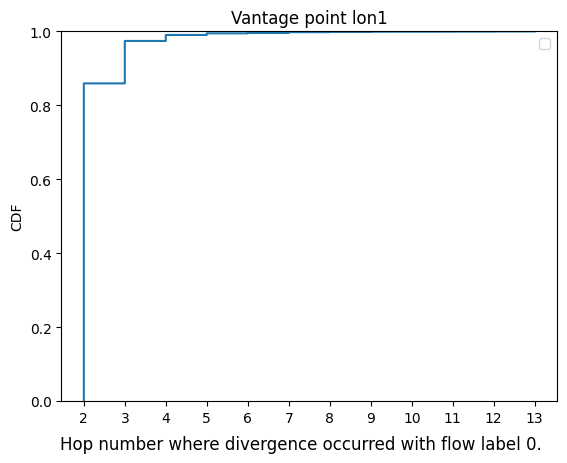

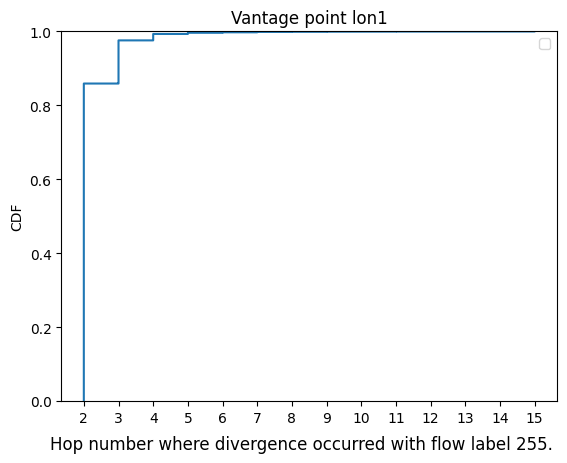

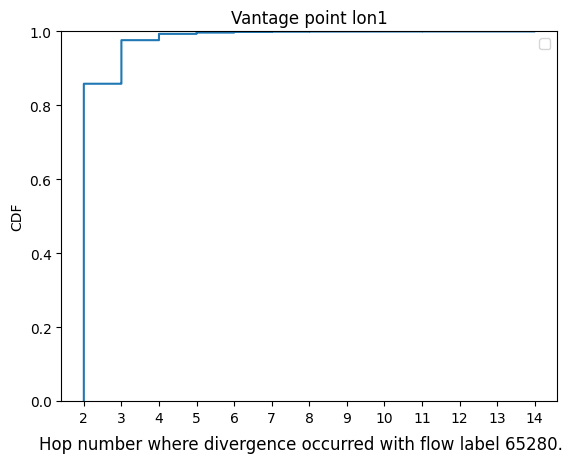

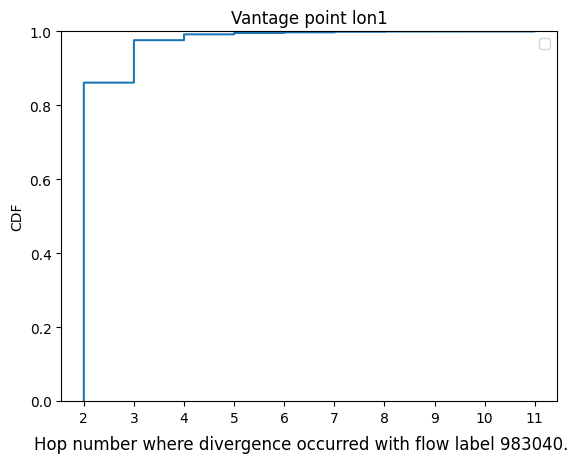

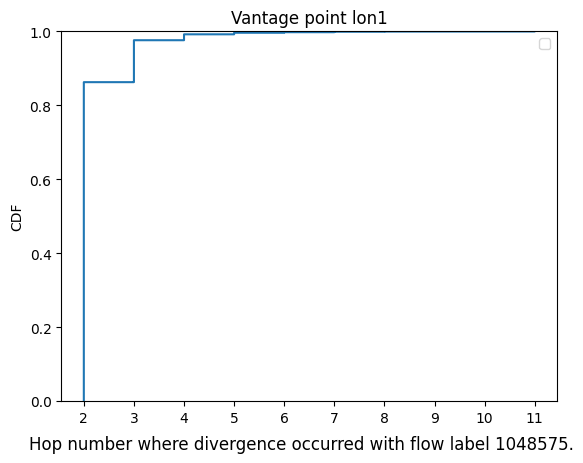

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_len_of_longest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_len_of_shortest_list(list_of_lists: list) -> int:
    # Get the length of the shortest list in list_of_lists
    shortest_list_len = len(list_of_lists[0])
    for lst in list_of_lists:
        if len(lst) < shortest_list_len:
            shortest_list_len = len(lst)
    return shortest_list_len

def get_divergence_hop_number(df: pd.DataFrame) -> str:
    # Setup: creating the combined columns, represented as a list of tuples
    zipped_list = list()
    for row in dst_df.itertuples():
        hop_ip_addresses = row[10].split()
        #hop_numbers = row[11].split()
        try:
            hop_numbers = [int(i) for i in row[11].split()]
        except ValueError:
            print("valueError")
            print(hop_numbers)
            return None
        zipped = list(zip(hop_ip_addresses, hop_numbers, strict=True))
        zipped_list.append(zipped)
        
    # If the zipped list is empty, return immediately
    if not zipped_list:
        return None
    
    longest_list: list = zipped_list[0]
    for i in zipped_list:
        if len(i) > len(longest_list):
            longest_list = i

    # Compare the items in the two lists and get the hop number
    shortest_list_len = get_len_of_shortest_list(zipped_list)
    for i in range(shortest_list_len):
        try:
            if zipped_list[0][i] != zipped_list[1][i]:
                return min(zipped_list[0][i][1], zipped_list[1][i][1])
        except IndexError:
            return longest_list[0][i][1]
    # If we got this far, the hops did not diverge
    return None

for flow_label in FLOW_LABELS:
    divergence_data = list()
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        divergence_data.append(
            get_divergence_hop_number(dst_df))
    # Create CDF Plot
    ndiv_count = divergence_data.count(None)
    #res = [int(i) for i in divergence_data if i != None]
    res = list()
    for i in divergence_data:
        if i != None:
            try:
                hop_num = int(i)
                res.append(hop_num)
            except ValueError:
                #print(f"valueError: {i}")
                pass
    sns.ecdfplot(data=res)
    plt.legend()
    plt.xticks(np.arange(min(res), max(res)+1, 1.0))
    plt.ylabel("CDF")
    plt.title(f"Vantage point {vantage_point}")
    plt.figtext(0.5, 0.01, f"Hop number where divergence occurred with flow label {flow_label}.", wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

## What are the IP-addresses of the load balancers we measured, and how many unique load balancers have we measured?
### Note: This is not a measurement of *all* load balancers, but it is a measurement of the number of load balancers we encounter when the first path divergence is detected.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_length_of_longest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_length_of_shortest_list(list_of_lists: list) -> int:
    # Get the length of the shortest list in list_of_lists
    shortest_list_len = len(list_of_lists[0])
    for lst in list_of_lists:
        if len(lst) < shortest_list_len:
            shortest_list_len = len(lst)
    return shortest_list_len

# If the paths diverge at the first hop, we return the unique
# hop IP(s) of the first hop(s).
# Erlend note: Maybe not correct, as the load balancer
# that caused the paths to diverge in this case is the
# load balancer with TTL=1
# The better thing to do would be to return the IP
# address of the default gateway.
def get_divergence_hop_ip(df: pd.DataFrame) -> str:
    """
    Compare two rows and get the hop IP where they diverge.
    """
    # Setup: creating the combined columns, represented as a list of tuples
    zipped_list = list()
    for row in dst_df.itertuples():
        hop_ip_addresses = row[10].split()
        hop_numbers = row[11].split()
        zipped = list(zip(hop_ip_addresses, hop_numbers, strict=True))
        zipped_list.append(zipped)

    # Compare the items in the two lists and get the load balancer IP
    longest_list_len = get_length_of_longest_list(zipped_list)
    for i in range(longest_list_len):
        try:
            if zipped_list[0][i] != zipped_list[1][i]:
                if i != 0:
                    # We are returning the previous IP (the last IP that was equal),
                    # as we are assuming that this is the load balancer that caused the
                    # paths to diverge.
                    min_current_hop_numbers = min(int(zipped_list[0][i][1]),int(zipped_list[1][i][1]))
                    previous_ip = zipped_list[0][i-1][0]
                    previous_hop_number = int(zipped_list[0][i-1][1])
                    if (min_current_hop_numbers - 1) == previous_hop_number:
                        return previous_ip
        except IndexError:
            # If we get an IndexError, it means that one of hop lists was longer than the other.
            # Because we can't assume that the previous hop actually was a load balancer (we need at least 2 
            # hops to compare against each other), we simply return None here, meaning that the comparison
            # is invalid.
            return None
    # If we got this far, the hops did not diverge
    return None

for flow_label in FLOW_LABELS:
    load_balancer_ips = list()
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        load_balancer_ips.append(
            get_divergence_hop_ip(dst_df))
    load_balancers = [ip for ip in load_balancer_ips if ip != None]
    unique_lb = set(load_balancers)
    # Incrementing by 1 to account for TTL=2
    num_unique_lb = len(unique_lb) + 1
    print(f"Number of unique load balancers for flow label: {flow_label}:")
    print(num_unique_lb)

Number of unique load balancers for flow label: 0:
74
Number of unique load balancers for flow label: 255:
72
Number of unique load balancers for flow label: 65280:
64
Number of unique load balancers for flow label: 983040:
79
Number of unique load balancers for flow label: 1048575:
76


## How many unique paths do we have that diverge? Is there an overlap in the paths that diverge?
### It would be interesting to contrast the number of unique routers at which a path change happened with the number of unique paths that diverge, for each flow label.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_length_of_longest_list(list_of_lists: list) -> int:
    """
    Get the length of the longest list in list_of_lists
    """
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_paths_that_diverge(df: pd.DataFrame) -> list:
    """
    Get a list of all path hashes where a divergence was detected.
    """
    path_hashes = list()
    for row in df.itertuples():
        path_hash = str(row[8])
        path_hashes.append(path_hash)
        
    if path_hashes:
        try:
            if path_hashes[0] != path_hashes[1]:
                return path_hashes
        except IndexError:
            return None
    return None


for flow_label in FLOW_LABELS:
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    path_hashes = list()
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        path_hashes_that_diverge: list = get_paths_that_diverge(dst_df)
        if path_hashes_that_diverge:
            path_hashes.extend(path_hashes_that_diverge)
    path_hashes = [str(i) for i in path_hashes if i != None]
    unique_paths_that_diverge = set(path_hashes)
    len_unique_paths = len(unique_paths_that_diverge)
    print(f"Number of unique divergent paths for flow label: {flow_label}")
    print(f"{len_unique_paths=}")

Number of unique divergent paths for flow label: 0
len_unique_paths=15910
Number of unique divergent paths for flow label: 255
len_unique_paths=15961
Number of unique divergent paths for flow label: 65280
len_unique_paths=15828
Number of unique divergent paths for flow label: 983040
len_unique_paths=16102
Number of unique divergent paths for flow label: 1048575
len_unique_paths=15769


## Path comparison with Tree data structure?

# the *total* number of unique routers where paths have diverged

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_length_of_longest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_length_of_shortest_list(list_of_lists: list) -> int:
    # Get the length of the shortest list in list_of_lists
    shortest_list_len = len(list_of_lists[0])
    for lst in list_of_lists:
        if len(lst) < shortest_list_len:
            shortest_list_len = len(lst)
    return shortest_list_len

# If the paths diverge at the first hop, we return the unique
# hop IP(s) of the first hop(s).
# Erlend note: Maybe not correct, as the load balancer
# that caused the paths to diverge in this case is the
# load balancer with TTL=1
# The better thing to do would be to return the IP
# address of the default gateway.
def get_divergence_hop_ip(df: pd.DataFrame) -> str:
    """
    Compare two rows and get the hop IP where they diverge.
    """
    # Setup: creating the combined columns, represented as a list of tuples
    zipped_list = list()
    for row in dst_df.itertuples():
        hop_ip_addresses = row[10].split()
        hop_numbers = row[11].split()
        hop_asns = row[13].split()
        zipped = list(zip(hop_ip_addresses, hop_numbers, hop_asns, strict=True))
        zipped_list.append(zipped)

    # Compare the items in the two lists and get the load balancer IP
    longest_list_len = get_length_of_longest_list(zipped_list)
    for i in range(longest_list_len):
        try:
            if zipped_list[0][i] != zipped_list[1][i]:
                if i != 0:
                    # We are returning the previous IP (the last IP that was equal),
                    # as we are assuming that this is the load balancer that caused the
                    # paths to diverge.
                    min_current_hop_numbers = min(int(zipped_list[0][i][1]),int(zipped_list[1][i][1]))
                    previous_ip = zipped_list[0][i-1][0]
                    previous_hop_number = int(zipped_list[0][i-1][1])
                    previous_hop_asn = str(zipped_list[0][i-1][2])
                    if (min_current_hop_numbers - 1) == previous_hop_number:
                        return (previous_ip, previous_hop_asn)
        except IndexError:
            # If we get an IndexError, it means that one of hop lists was longer than the other.
            # Because we can't assume that the previous hop actually was a load balancer (we need at least 2 
            # hops to compare against each other), we simply return None here, meaning that the comparison
            # is invalid.
            return None
    # If we got this far, the hops did not diverge
    return None

routers = list()
asns = list()
combined = list()
for flow_label in FLOW_LABELS:
    load_balancers = list()
    tuple_asns = list()
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        divergence_hop_tuple: tuple = get_divergence_hop_ip(dst_df)
        if divergence_hop_tuple is not None:
            load_balancers.append(divergence_hop_tuple[0])
            tuple_asns.append(divergence_hop_tuple[1])
    routers.extend(load_balancers)
    asns.extend(tuple_asns)

# The total number of unique routers where paths have diverged:
# NB. Does not include TTL=2 or paths with missing data (easier to explain with figure)

# Find the ASN distribution
combined = zip(routers, asns)
unique = set(combined)
asns = list()
print(f"Total number of unique load balancers where paths have diverged: {len(unique)}")
for i in unique:
    asns.append(i[1])

#np_routers = np.array(routers)
#unique_routers = np.unique(np_routers)
# NB. Consider perhaps incrementing by 1 to account for TTL=2
#num_unique_lb = unique_routers.size
#print(f"Number of unique load balancers for vantage point {vantage_point}:")
#print(num_unique_lb)

print(f"ASN distribution of the load balancers")
asn_series = pd.Series(asns)
asn_vc = asn_series.value_counts()
print(f"Value count:\n{asn_vc}")

#fig, ax = plt.subplots()
#ax.pie(asn_vc, labels=labels)
#ax.set_title('ASN distribution of the load balancers')
#plt.tight_layout()
#plt.show()

Total number of unique load balancers where paths have diverged: 175
ASN distribution of the load balancers
Value count:
NULL      50
2914      22
3356      22
1299      15
9002       7
174        4
201011     4
6939       3
29551      2
7473       2
6762       2
13030      2
52320      2
24785      2
50673      1
207781     1
30844      1
23520      1
45899      1
42525      1
37100      1
29119      1
34156      1
4755       1
13237      1
35280      1
34927      1
6453       1
39912      1
263042     1
12552      1
20965      1
34968      1
6663       1
8641       1
37662      1
6461       1
12859      1
20473      1
9498       1
25899      1
24971      1
4637       1
6696       1
15169      1
17882      1
46887      1
39537      1
3327       1
8167       1
dtype: int64


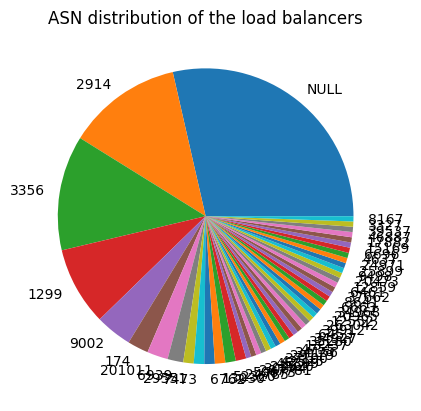

In [18]:
#asn_vc.plot.pie(label="", title="ASN distribution of the load balancers", labeldistance=None)
asn_vc.plot.pie(label="", title="ASN distribution of the load balancers")
plt.show(block=True)

# AS mapping of these 50’ish routers per vantage point. tell us as much as you can about them!

## Erlend note: Might be interesting to combine this with hop number data?
## E.g.: The traces that diverged at TTL=2 all belong to ASN 3000 

In [19]:
!whois 'AS3356'


#
# ARIN WHOIS data and services are subject to the Terms of Use
# available at: https://www.arin.net/resources/registry/whois/tou/
#
# If you see inaccuracies in the results, please report at
# https://www.arin.net/resources/registry/whois/inaccuracy_reporting/
#
# Copyright 1997-2023, American Registry for Internet Numbers, Ltd.
#


ASNumber:       3356
ASName:         LEVEL3
ASHandle:       AS3356
RegDate:        2000-03-10
Updated:        2018-02-20    
Ref:            https://rdap.arin.net/registry/autnum/3356



OrgName:        Level 3 Parent, LLC
OrgId:          LPL-141
Address:        100 CenturyLink Drive
City:           Monroe
StateProv:      LA
PostalCode:     71203
Country:        US
RegDate:        2018-02-06
Updated:        2023-01-03
Comment:        ADDRESSES WITHIN THIS BLOCK ARE NON-PORTABLE ANY ISP ANNOUNCING OR TRANSITING PORTIONS WITHIN OUR RANGES SHOULD NOT RELY ON PRESENTED LOA'S UNLESS THOSE RANGES ARE ALSO ANNOUNCED TO A LUMEN ASN. 
Comment:        
Comment:   

In [20]:
import whois

#w = whois.whois('2a00:1450:400f:801::200e')
w = whois.whois('AS3356')
print(w.expiration_date)
print(w.text)
print(w)

None

{
  "domain_name": null,
  "registrar": null,
  "whois_server": null,
  "referral_url": null,
  "updated_date": null,
  "creation_date": null,
  "expiration_date": null,
  "name_servers": null,
  "status": null,
  "emails": null,
  "dnssec": null,
  "name": null,
  "org": null,
  "address": null,
  "city": null,
  "state": null,
  "registrant_postal_code": null,
  "country": null
}
